# Representaciones Computacionales: Estructuras de Datos Geográficos

**Basado en:** [Geographic Thinking for Data Scientists](https://geographicdata.science/book/notebooks/01_geo_thinking.html)  
**Autores originales:** Rey, Arribas-Bel & Wolf (2020)

---

## ¿Por qué necesitamos estructuras de datos especiales para geografía?

Los datos geográficos tienen una propiedad especial: **todo ocurre en algún lugar**. Pero la ubicación no es solo una coordenada — nos permite entender las *relaciones* entre observaciones. Como señaló el geógrafo Waldo Tobler:

> *"Las cosas cercanas están más relacionadas entre sí que las cosas distantes."* — Primera Ley de la Geografía

Para representar estos datos en una computadora, necesitamos **estructuras de datos** que conecten los modelos conceptuales con la tecnología.

### Las tres estructuras fundamentales:

| Modelo conceptual | Estructura computacional | Librería Python |
|---|---|---|
| **Objetos** (entidades discretas) | Tabla geográfica | `geopandas` |
| **Campos** (superficies continuas) | Grillas / Arrays | `xarray`, `numpy` |
| **Redes** (conexiones entre objetos) | Grafo espacial | `networkx`, `pysal` |

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Point, Polygon

print("Librerías cargadas correctamente ✓")

Librerías cargadas correctamente ✓


In [2]:
#origenes_viajes_gpkg   = gpd.read_file("datos/eod_stgo/origenes_viajes.gpkg")
#origenes_viajes_geojson = gpd.read_file("datos/eod_stgo/origenes_viajes.geojson")
origenes_viajes_shp = gpd.read_file("datos/eod_stgo/origenes_viajes.shp")

---
## 1. Tablas Geográficas (`GeoDataFrame`)

Las **tablas geográficas** almacenan información sobre *objetos discretos*. Son como una tabla de pandas normal, pero con **una columna especial de geometría** que representa la forma y posición del objeto en el espacio.

La geografía se convierte en "un atributo más", lo que permite combinar información espacial y no espacial de forma natural.

**Casos de uso:** ciudades, países, edificios, paradas de metro, delimitaciones administrativas.

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
mpl.rcParams["figure.dpi"] = 96
# esto depende de las fuentes que tengas instaladas en tu sistema.
mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"
%config InlineBackend.figure_format = 'retina'

## Ver las primeras filas, igual que en Pandas

In [22]:
print("GeoDataFrame (la geografía es solo una columna más):")
origenes_viajes_shp.head()


GeoDataFrame (la geografía es solo una columna más):


,Hogar,Persona,Viaje,Etapas,ComunaOrig,ComunaDest,SectorOrig,SectorDest,ZonaOrigen,ZonaDestin,...,NumBicNino,Propiedad,MontoDiv,ImputadoDi,MontoArr,ImputadoAr,IngresoHog,FactorHoga,PesoLabora,geometry
0,173431,17343102,1734310202,1,94.0,94.0,2.0,2.0,400,407,...,0,2,81067.0,1,120000,0,789356,76.81028,53.391740,POINT (335208.719 6288387.000)
1,173431,17343102,1734310201,1,94.0,94.0,2.0,2.0,407,400,...,0,2,81067.0,1,120000,0,789356,76.81028,53.391740,POINT (338812.281 6292391.000)
2,173431,17343101,1734310101,2,94.0,328.0,2.0,2.0,407,126,...,0,2,81067.0,1,120000,0,789356,76.81028,37.886589,POINT (338812.281 6292391.000)
3,173431,17343101,1734310102,1,328.0,70.0,2.0,4.0,126,15,...,0,2,81067.0,1,120000,0,789356,76.81028,52.214368,POINT (343526.594 6297299.000)
4,173431,17343101,1734310103,2,70.0,94.0,4.0,2.0,15,407,...,0,2,81067.0,1,120000,0,789356,76.81028,52.214368,POINT (345015.906 6297331.000)


In [23]:
# Ver el tipo de objeto
type(origenes_viajes_shp)  # geopandas.geodataframe.GeoDataFrame

geopandas.geodataframe.GeoDataFrame

In [24]:
# Ver las dimensiones: filas x columnas
origenes_viajes_shp.shape

(65591, 98)

## La columna geometry

In [25]:
origenes_viajes_shp.geometry.head()

0    POINT (335208.719 6288387.000)
1    POINT (338812.281 6292391.000)
2    POINT (338812.281 6292391.000)
3    POINT (343526.594 6297299.000)
4    POINT (345015.906 6297331.000)
Name: geometry, dtype: geometry

A diferencia de un DataFrame de Pandas, un GeoDataFrame tiene una columna especial llamada 'geometry' que almacena la información espacial de cada fila. En este caso, cada fila tiene un PUNTO (coordenadas x, y de un origen de viaje)

## El CRS: Sistema de Referencia

El CRS (Coordinate Reference System) define cómo se interpretan las coordenadas. Es fundamental para trabajar con datos espaciales, porque sin CRS no sabemos
en qué parte del mundo están los puntos ni en qué unidad están las distancias.



In [26]:
# Ver el CRS del archivo
origenes_viajes_shp.crs

<Projected CRS: EPSG:32719>
Name: WGS 84 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Chile. Colombia. Peru.
- bounds: (-72.0, -80.0, -66.0, 0.0)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Sistema de Referencia de Coordenadas (CRS)

El CRS define **cómo se representan las ubicaciones geográficas** en un plano 2D.
En este caso usamos **EPSG:32719 (WGS 84 / UTM zona 19S)**, un sistema proyectado en **metros** 
basado en el datum WGS 84 (el mismo del GPS).

La proyección UTM divide la Tierra en 60 zonas de 6° de longitud. 
La **zona 19S** cubre la franja entre **72°O y 66°O** en el hemisferio sur, 
abarcando partes de Argentina, Chile, Bolivia, Perú y Brasil.

Al trabajar en metros (y no en grados), es fácil calcular distancias y áreas con precisión.

![utm](https://raw.githubusercontent.com/daniopitz/geodata/main/img/utm.jpg)

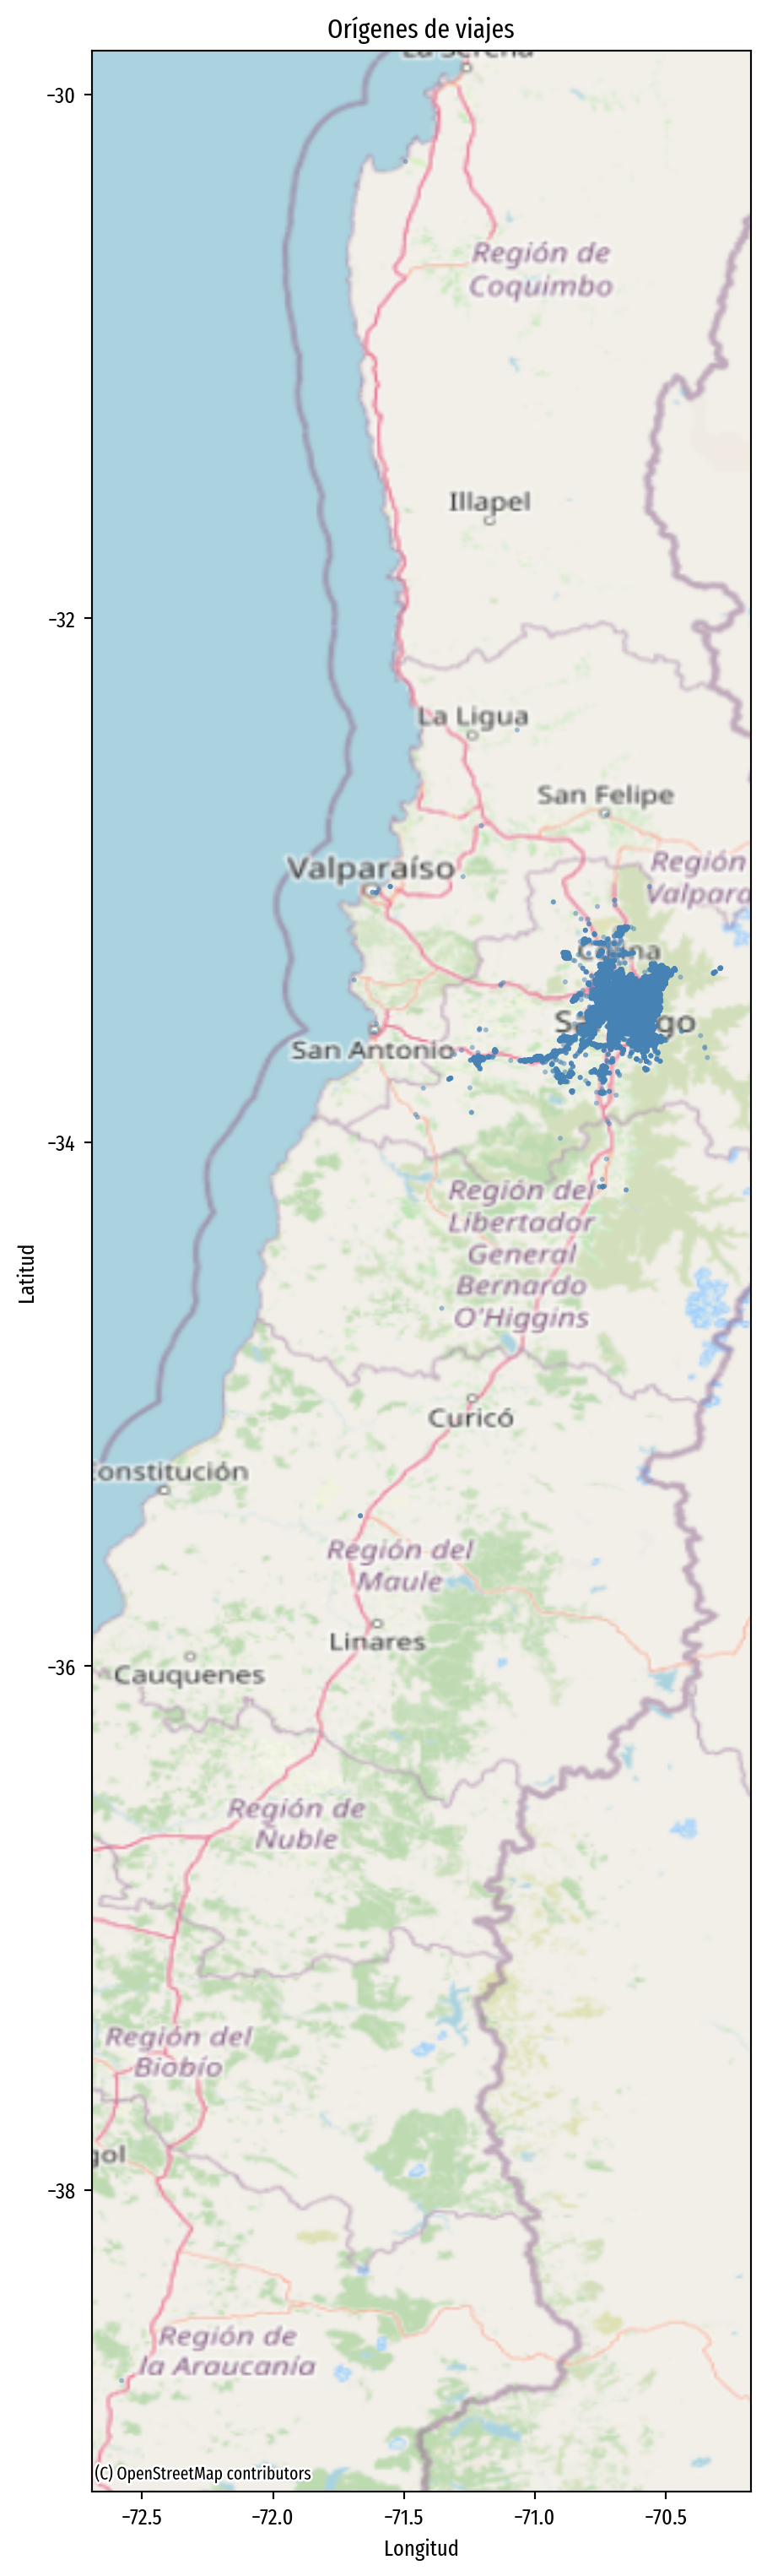

In [27]:
gdf_clean = origenes_viajes_shp.to_crs(epsg=4326)

# Ver los valores extremos
gdf_clean = gdf_clean[
    (gdf_clean.geometry.x > -80) &  # ajusta estos valores
    (gdf_clean.geometry.y > -40)
]

fig, ax = plt.subplots(figsize=(10, 16))
gdf_clean.plot(ax=ax, color='steelblue', markersize=5, edgecolor='none', alpha=0.5)
ctx.add_basemap(ax, crs=gdf_clean.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('Orígenes de viajes')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.tight_layout()
plt.show()



## Geometrías tipo Polígono

Hasta ahora trabajamos con **puntos**. Otro tipo de geometría fundamental en datos espaciales son los **polígonos**: figuras cerradas que representan áreas o superficies.

Algunos ejemplos comunes:
- Límites administrativos (comunas, regiones, países)
- Manzanas o predios
- Áreas verdes, lagos, zonas de inundación

En este caso cargaremos las **comunas de la Región Metropolitana** a partir del Censo 2017 (INE Chile), donde cada polígono representa el límite administrativo de una comuna.

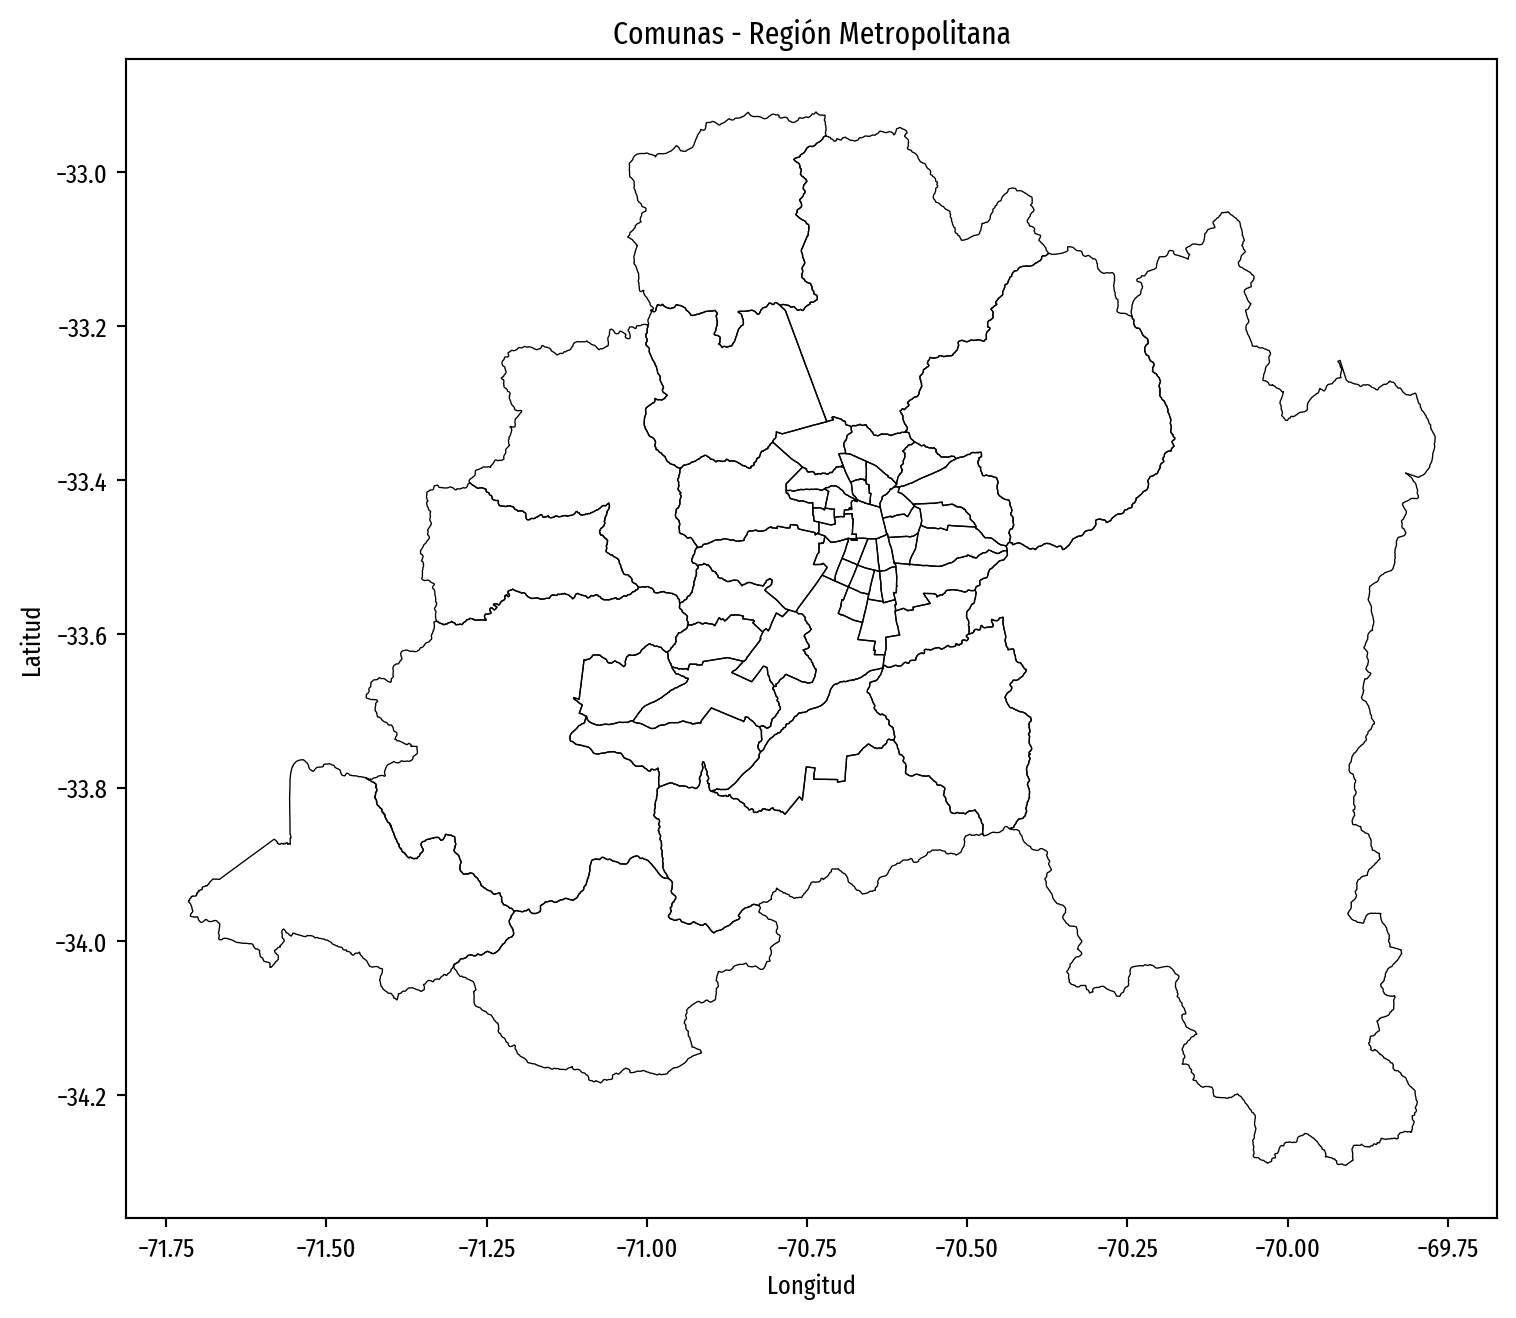

In [34]:
rm_comunas = gpd.read_file("../data/external/censo2017/geometria/R13/COMUNA_C17.shp")

fig, ax = plt.subplots(figsize=(8, 12))

rm_comunas.to_crs(epsg=4326).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

ax.set_title('Comunas - Región Metropolitana')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.tight_layout()
plt.show()

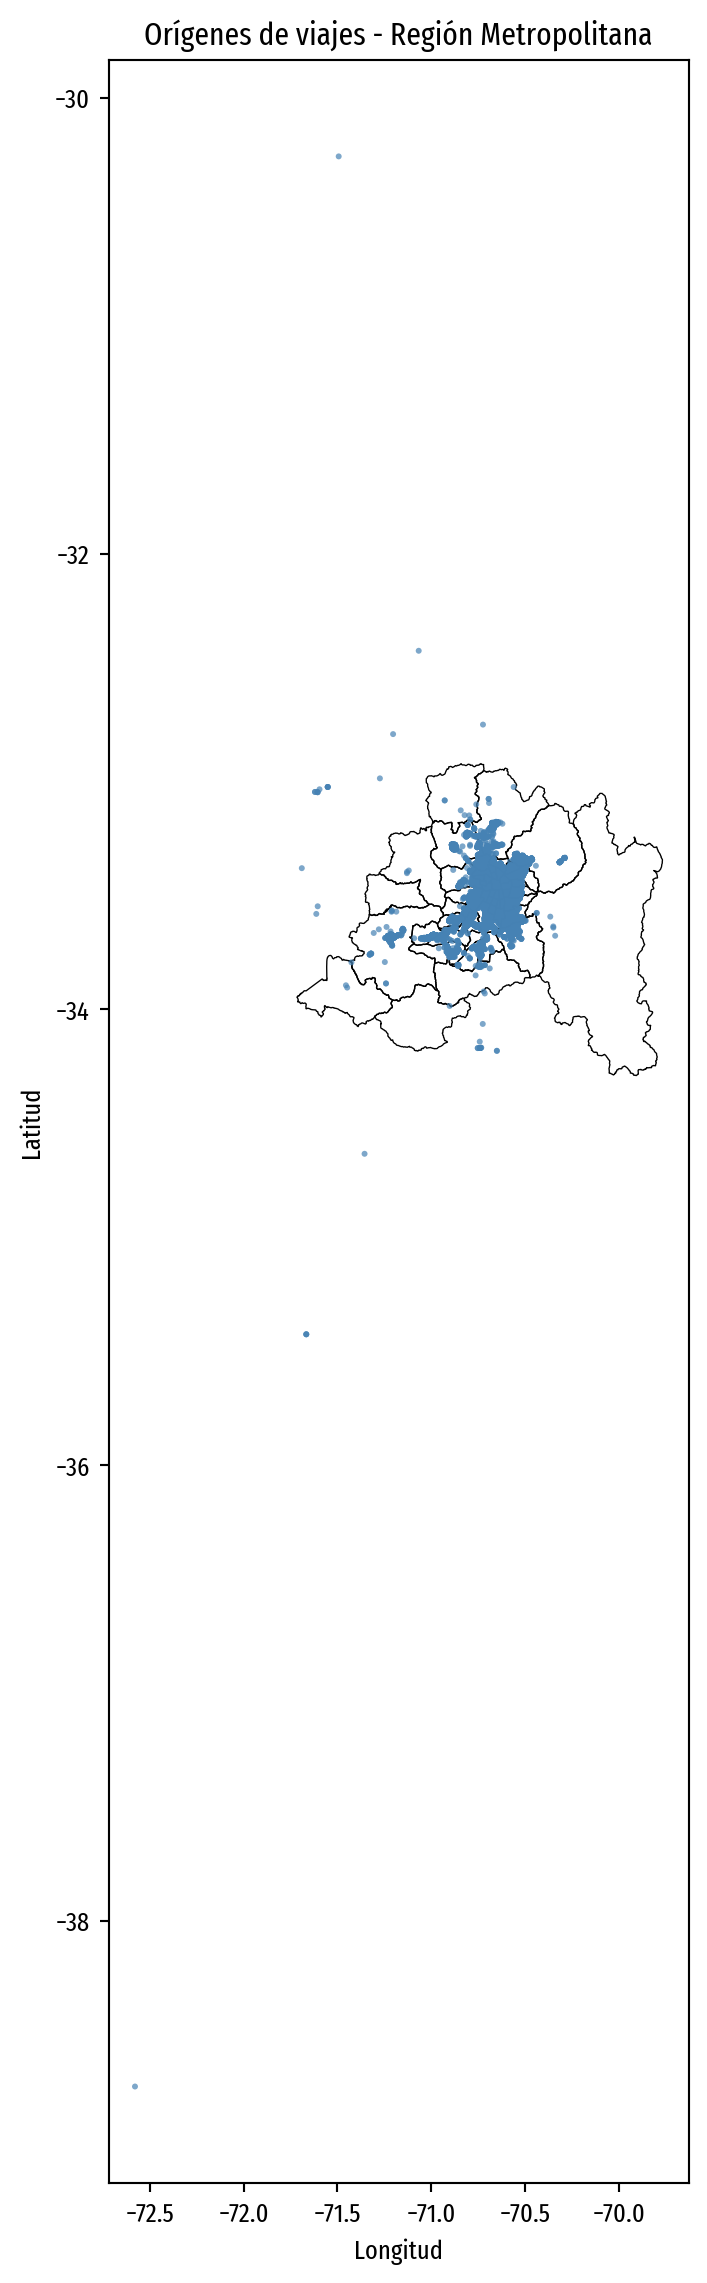

In [35]:
fig, ax = plt.subplots(figsize=(8, 12))

rm_comunas.to_crs(epsg=4326).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
gdf_clean.plot(ax=ax, color='steelblue', markersize=5, edgecolor='none', alpha=0.7)

ax.set_title('Orígenes de viajes - Región Metropolitana')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.tight_layout()
plt.show()

**Conclusión:** El `GeoDataFrame` de `geopandas` es la implementación Python de la tabla geográfica. La clave es que la geometría es simplemente *una columna más*, lo que permite usar todas las herramientas de pandas junto con operaciones espaciales.

---


In [36]:
## 2. Superficies (Campos Continuos)

Las **superficies** representan fenómenos *continuos* que podrían medirse en cualquier punto del espacio: temperatura, altitud, densidad de población, contaminación atmosférica.

Se implementan como **grillas (arrays 2D)** donde:
- Las **filas** representan latitudes
- Las **columnas** representan longitudes  
- Los **valores de las celdas** almacenan la medición en ese punto

SyntaxError: invalid decimal literal (2025510252.py, line 5)

In [ ]:
# --- Simulamos una superficie de temperatura ---
# En la práctica vendría de satélites, sensores, o modelos climáticos

# Definir el área geográfica (Chile central, simplificado)
lons = np.linspace(-74, -68, 60)  # 60 columnas (longitudes)
lats = np.linspace(-20, -45, 80)  # 80 filas (latitudes)

LON, LAT = np.meshgrid(lons, lats)

# Temperatura: más fría al sur y en la montaña (simplificado)
temperatura = 28 + (LAT + 20) * 0.7 + np.random.normal(0, 1.5, LON.shape)

print(f"Forma del array: {temperatura.shape}")
print(f"  → {temperatura.shape[0]} filas (latitudes) × {temperatura.shape[1]} columnas (longitudes)")
print(f"Rango de temperatura: {temperatura.min():.1f}°C a {temperatura.max():.1f}°C")

In [ ]:
# --- Visualización de la superficie ---
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Como imagen raster (estructura real de almacenamiento)
im = axes[0].imshow(temperatura, cmap='RdYlBu_r', origin='upper',
                    extent=[lons[0], lons[-1], lats[-1], lats[0]])
plt.colorbar(im, ax=axes[0], label='Temperatura (°C)')
axes[0].set_title('Superficie como raster / imagen\n(cada píxel = una celda del array)')
axes[0].set_xlabel('Longitud'); axes[0].set_ylabel('Latitud')

# Como mapa de contornos (interpolando entre celdas)
contorno = axes[1].contourf(LON, LAT, temperatura, levels=15, cmap='RdYlBu_r')
plt.colorbar(contorno, ax=axes[1], label='Temperatura (°C)')
axes[1].contour(LON, LAT, temperatura, levels=15, colors='white', linewidths=0.3, alpha=0.5)
axes[1].set_title('Misma superficie como mapa de contornos\n(énfasis en la continuidad)')
axes[1].set_xlabel('Longitud')

plt.suptitle('Campo continuo: Temperatura (superficie simulada)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# --- Cuando hay múltiples fenómenos: el "data cube" ---
# Por ejemplo: temperatura + precipitación + viento → array 3D

precipitacion = 300 - (LAT + 20) * 8 + np.random.normal(0, 30, LON.shape)
viento = 15 + np.random.normal(0, 3, LON.shape)

cubo = np.stack([temperatura, precipitacion, viento], axis=0)
variables = ['Temperatura (°C)', 'Precipitación (mm)', 'Viento (km/h)']

print(f"Forma del cubo de datos: {cubo.shape}")
print(f"  → {cubo.shape[0]} bandas × {cubo.shape[1]} filas × {cubo.shape[2]} columnas")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
cmaps = ['RdYlBu_r', 'Blues', 'Greens']
for i, (ax, var, cmap) in enumerate(zip(axes, variables, cmaps)):
    im = ax.imshow(cubo[i], cmap=cmap, origin='upper',
                   extent=[lons[0], lons[-1], lats[-1], lats[0]])
    plt.colorbar(im, ax=ax, shrink=0.8)
    ax.set_title(f'Banda {i+1}:\n{var}', fontsize=10)
    ax.set_xlabel('Longitud')

plt.suptitle('Data Cube: tres variables geográficas sobre la misma grilla', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

**Conclusión:** Las superficies se almacenan como arrays numéricos. Tanto las filas como las columnas codifican posición geográfica, y los valores codifican el fenómeno medido. Cuando hay múltiples variables o momentos en el tiempo, se forman *data cubes* (arrays 3D o más). La librería estándar en Python para esto es `xarray`.

---
## 3. Redes / Grafos Espaciales

Los **grafos espaciales** capturan *relaciones entre objetos* mediadas por el espacio. Responden a la pregunta: **¿quién está conectado con quién, y cómo?**

Ejemplos: red de metro, sistema de ríos, red de carreteras, conectividad entre vecindarios.

> ⚠️ **Distinción importante:** Una tabla geográfica puede almacenar el *trazado físico* de una calle (su forma y longitud). Un grafo espacial almacena la *estructura de conexiones* entre calles (qué intersección lleva a cuál).

In [ ]:
# --- Construimos una red de metro simplificada ---

# Nodos: estaciones con coordenadas geográficas
estaciones = {
    'Central'    : (-70.664, -33.437),
    'Baquedano'  : (-70.633, -33.437),
    'Santa Ana'  : (-70.677, -33.440),
    'Plaza Italia': (-70.638, -33.434),
    'Tobalaba'   : (-70.608, -33.436),
    'Los Leones' : (-70.615, -33.426),
    'Manuel Montt': (-70.627, -33.420),
    'Parque Bustamante': (-70.630, -33.432),
}

# Aristas: conexiones entre estaciones (con tiempo en minutos)
conexiones = [
    ('Santa Ana', 'Central', {'tiempo': 2, 'linea': 1}),
    ('Central', 'Baquedano', {'tiempo': 3, 'linea': 1}),
    ('Baquedano', 'Plaza Italia', {'tiempo': 2, 'linea': 1}),
    ('Plaza Italia', 'Tobalaba', {'tiempo': 4, 'linea': 1}),
    ('Baquedano', 'Parque Bustamante', {'tiempo': 2, 'linea': 5}),
    ('Parque Bustamante', 'Los Leones', {'tiempo': 3, 'linea': 5}),
    ('Los Leones', 'Manuel Montt', {'tiempo': 2, 'linea': 5}),
    ('Tobalaba', 'Los Leones', {'tiempo': 2, 'linea': 4}),
]

# Construir el grafo
G = nx.Graph()
for nombre, coords in estaciones.items():
    G.add_node(nombre, pos=coords, lon=coords[0], lat=coords[1])
G.add_edges_from(conexiones)

print(f"Red de metro:")
print(f"  Nodos (estaciones): {G.number_of_nodes()}")
print(f"  Aristas (conexiones): {G.number_of_edges()}")
print(f"\nAtributos de un nodo: {G.nodes['Baquedano']}")
print(f"Atributos de una arista: {G.edges['Central', 'Baquedano']}")

In [ ]:
# --- Visualización del grafo espacial ---
pos = nx.get_node_attributes(G, 'pos')

# Separar aristas por línea
linea1 = [(u, v) for u, v, d in G.edges(data=True) if d.get('linea') == 1]
linea4 = [(u, v) for u, v, d in G.edges(data=True) if d.get('linea') == 4]
linea5 = [(u, v) for u, v, d in G.edges(data=True) if d.get('linea') == 5]

fig, ax = plt.subplots(figsize=(10, 6))

nx.draw_networkx_edges(G, pos, edgelist=linea1, edge_color='red',   width=4, ax=ax, label='Línea 1')
nx.draw_networkx_edges(G, pos, edgelist=linea4, edge_color='blue',  width=4, ax=ax, label='Línea 4')
nx.draw_networkx_edges(G, pos, edgelist=linea5, edge_color='green', width=4, ax=ax, label='Línea 5')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='white', edgecolors='black', linewidths=2, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

# Etiquetas de tiempo
edge_labels = {(u, v): f"{d['tiempo']}m" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, ax=ax)

ax.legend(loc='upper left', fontsize=10)
ax.set_title('Red de Metro — Grafo Espacial\n(nodos=estaciones, aristas=conexiones)', fontsize=12, fontweight='bold')
ax.set_xlabel('Longitud'); ax.set_ylabel('Latitud')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# --- Análisis básico de la red ---
print("=== Análisis de la red de metro ===")
print()

# Centralidad de grado: ¿cuántas conexiones tiene cada estación?
centralidad = dict(G.degree())
print("Conexiones por estación (grado):")
for estacion, grado in sorted(centralidad.items(), key=lambda x: -x[1]):
    print(f"  {estacion:<25} {grado} conexiones")

print()

# Ruta más corta entre dos estaciones (por número de paradas)
origen, destino = 'Santa Ana', 'Manuel Montt'
ruta = nx.shortest_path(G, origen, destino)
print(f"Ruta más corta (mín. paradas) de {origen} → {destino}:")
print(f"  {' → '.join(ruta)}  ({len(ruta)-1} paradas)")

# Ruta más rápida (por tiempo)
ruta_rapida = nx.shortest_path(G, origen, destino, weight='tiempo')
tiempo_total = sum(G[ruta_rapida[i]][ruta_rapida[i+1]]['tiempo'] for i in range(len(ruta_rapida)-1))
print(f"\nRuta más rápida (mín. tiempo) de {origen} → {destino}:")
print(f"  {' → '.join(ruta_rapida)}  ({tiempo_total} minutos)")

**Conclusión:** Los grafos espaciales codifican *topología*, es decir, quién está conectado con quién. Esto habilita análisis como rutas más cortas, centralidad, y comunidades. La librería principal en Python es `networkx`; para análisis de pesos espaciales se usa `pysal`.

---
## Resumen: Las tres estructuras y sus herramientas

In [ ]:
# --- Visualización comparativa de las tres estructuras ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Tabla geográfica
gdf.plot(ax=axes[0], color='steelblue', markersize=100, edgecolor='white')
for _, row in gdf.iterrows():
    axes[0].annotate(row['ciudad'], xy=(row.geometry.x, row.geometry.y),
                     xytext=(4, 4), textcoords='offset points', fontsize=8)
axes[0].set_title('1. Tabla Geográfica\n(objetos discretos)', fontweight='bold')
axes[0].set_xlabel('geopandas → GeoDataFrame')

# 2. Superficie
im = axes[1].imshow(temperatura, cmap='RdYlBu_r', origin='upper',
                    extent=[lons[0], lons[-1], lats[-1], lats[0]], aspect='auto')
plt.colorbar(im, ax=axes[1], label='°C', shrink=0.8)
axes[1].set_title('2. Superficie (Campo continuo)\n(fenómeno medible en cualquier punto)', fontweight='bold')
axes[1].set_xlabel('numpy / xarray → ndarray')

# 3. Grafo espacial
nx.draw_networkx_edges(G, pos, ax=axes[2], width=2, edge_color='gray')
nx.draw_networkx_nodes(G, pos, ax=axes[2], node_size=300,
                       node_color='white', edgecolors='black', linewidths=2)
nx.draw_networkx_labels(G, pos, ax=axes[2], font_size=7)
axes[2].set_title('3. Grafo Espacial\n(relaciones y conexiones)', fontweight='bold')
axes[2].set_xlabel('networkx / pysal → Graph')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Representaciones Computacionales de Datos Geográficos',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Reflexión final: ¿La separación está desapareciendo?

Como señalan Rey, Arribas-Bel y Wolf, las fronteras entre estas tres estructuras se están difuminando:

- El **Machine Learning** hace más fácil convertir datos entre representaciones (problema de *change of support*).
- Sistemas como **H3 de Uber** o **S2 de Google** buscan una representación hexagonal universal.
- Datos de población (tradicionalmente en tablas) ahora también se publican como **rasters continuos** (ej: WorldPop).

Pero la pregunta sigue siendo válida: **¿se *puede* usar esta representación para mi problema, o se *debería* usar?**

La respuesta depende tanto del fenómeno como del objetivo analítico.

---
*Notebook preparado para curso de Ciencia de Datos Geográficos.*  
*Referencia: [Geographic Data Science with Python](https://geographicdata.science/book/) — Rey, Arribas-Bel & Wolf (2020)*